# Spatio-Temporal Hotspot Exploration — Squid Catch (2000–2020)

This notebook performs exploratory analysis on squid fishing hotspots derived
from PostGIS. It focuses on temporal trends in catch, effort, and CPUE, and
serves as a validation step prior to visualization in QGIS and dashboarding.
Hotspots are derived from squid fishing events aggregated into a 0.25° polygon grid. 
Catch and effort metrics are summarized at the grid-cell and annual level. 
For spatial visualization, CPUE is log-transformed to improve interpretability 
across highly skewed values, while reported statistics remain in original units.

---

## Executive Summary:

### Overview
An exploratory review of squid catch data from 2000–2020 reveals a highly
variable fishery characterized by pronounced boom–bust cycles. Total catch,
fishing effort (vessel days), and catch-per-unit-effort (CPUE) show weak
long-term alignment, indicating that interannual changes in squid productivity
are driven more by biological and environmental factors than by effort alone.

---

### 1. Catch Variability and Cycles
- Squid catches fluctuate sharply across the 20-year period, with no sustained
  long-term upward or downward trend.
- Peak production years include **2000**, **2007–2008**, and **2014–2015**, when
  total catch exceeded **200 million kg**.
- Extreme low-catch years (**2004** and **2016**) saw collapses to less than
  **15 million kg**, highlighting the sensitivity of squid stocks to short-term
  environmental conditions.

---

### 2. Fishing Effort Trends
- Vessel days declined substantially from early 2000s highs (≈4,000 days in
  2000) to a more stable range of approximately **1,500–2,300 days** after 2005.
- High catches in later years occurred without proportional increases in
  effort, suggesting that effort alone does not explain production outcomes.

---

### 3. CPUE as an Indicator of Stock Productivity
- CPUE exhibits strong interannual variability, ranging from approximately
  **2,600 kg/day (2004)** to over **70,000 kg/day (2015)**.
- The highest CPUE values (**2014–2015**) coincide with record catches and
  moderate effort, indicating years of exceptional stock availability or
  fishing efficiency.
- Low CPUE years (e.g., **2004, 2010, 2016**) signal poor stock conditions even
  when effort was not at its lowest.

---

### 4. Recent Conditions (2016–2020)
- Following the 2014–2015 peak, the fishery did not return to historical highs.
- Catch and CPUE remained moderate to low despite relatively stable effort,
  suggesting a shift toward lower productivity or increased frequency of weak
  recruitment years.

---

### Management and Analytical Implications
- Squid fisheries exhibit **high natural variability**, requiring flexible and
  adaptive management approaches.
- CPUE provides a valuable early signal of strong versus weak years and should
  be emphasized in monitoring frameworks.
- Fixed effort controls alone are unlikely to stabilize catch outcomes.
- These results support the use of **spatio-temporal hotspot mapping** in QGIS
  and dashboard tools to better contextualize productivity shifts and guide
  decision-making.

---


In [1]:

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sqlalchemy import create_engine
from dotenv import load_dotenv
load_dotenv()


True

## Connect to PostGIS Database

We connect directly to the PostgreSQL/PostGIS database to query
analysis-ready hotspot tables.

In [2]:

pguser = os.getenv("PGUSER")
pgpassword = os.getenv("PGPASSWORD")
pghost = os.getenv("PGHOST")
pgport = os.getenv("PGPORT")
pgdatabase = os.getenv("PGDATABASE")

assert all([pguser, pgpassword, pghost, pgport, pgdatabase]), \
    "One or more PostgreSQL environment variables are missing"

engine = create_engine(
    f"postgresql://{pguser}:{pgpassword}@{pghost}:{pgport}/{pgdatabase}"
)


## Load Hotspot Data

The `analysis.squid_hotspots` table contains spatially aggregated fishing
events with total catch and vessel-day effort.

In [3]:
sql = """
SELECT
    year,
    total_catch_kg,
    vessel_days,
    cpue,
    cpue_log,
    cell_geom
FROM analysis.squid_hotspots

"""

hotspots = gpd.read_postgis(
    sql,
    engine,
    geom_col="cell_geom",
    crs="EPSG:4326"
)

hotspots.head()

,year,total_catch_kg,vessel_days,cpue,cpue_log,cell_geom
0,2000,10923.903270,1,10923.903270,4.038378,"POLYGON ((-67.25 -51.5, -67 -51.5, -67 -51.25,..."
1,2000,12619.194110,1,12619.194110,4.101032,"POLYGON ((-67.25 -51, -67 -51, -67 -50.75, -67..."
2,2000,111728.265280,4,27932.066320,4.446103,"POLYGON ((-66.75 -53.5, -66.5 -53.5, -66.5 -53..."
3,2000,276302.048750,6,46050.341458,4.663233,"POLYGON ((-66.75 -53.25, -66.5 -53.25, -66.5 -..."
4,2000,21326.583933,2,10663.291966,4.027891,"POLYGON ((-66.75 -51.5, -66.5 -51.5, -66.5 -51..."


## Temporal Trends

We summarize total catch, effort, and CPUE by year to inspect long-term trends.

In [4]:
summary = (
    hotspots
    .groupby("year")
    .agg(
        total_catch_kg=("total_catch_kg", "sum"),
        vessel_days=("vessel_days", "sum")
    )
    .reset_index()
)

summary["cpue"] = summary["total_catch_kg"] / summary["vessel_days"]

summary.head()

,year,total_catch_kg,vessel_days,cpue
0,2000,2.479350e+08,4204,58975.968331
1,2001,1.319413e+08,3365,39209.883296
2,2002,8.820531e+07,3047,28948.246153
3,2003,1.217928e+08,2912,41824.449295
4,2004,9.786551e+06,1607,6089.950866


## Catch and CPUE Over Time

This plot provides a high-level view of fishing intensity and efficiency.

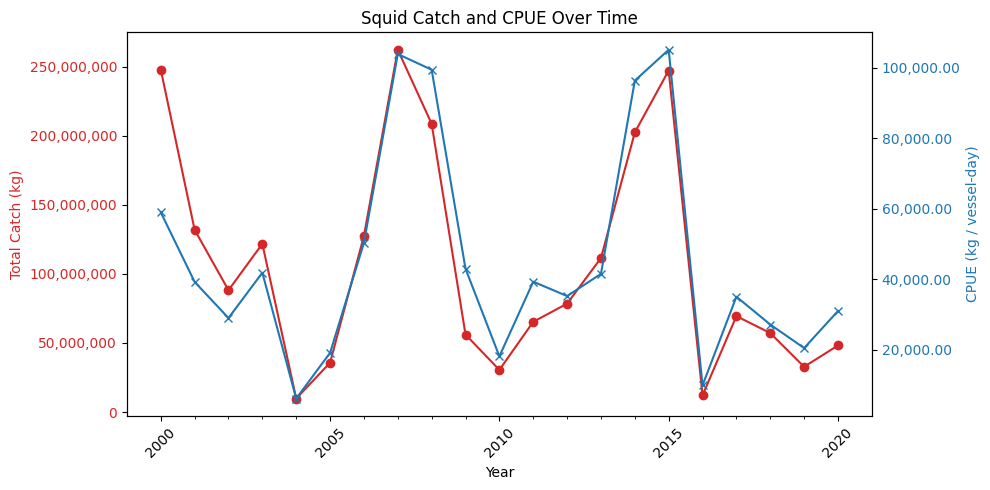

In [5]:

# Ensure year is integer
summary["year"] = summary["year"].astype(int)

fig, ax1 = plt.subplots(figsize=(10,5))

# Plot Total Catch (kg) with thousands separators
ax1.plot(summary["year"], summary["total_catch_kg"], color="tab:red", marker='o')
ax1.set_ylabel("Total Catch (kg)", color="tab:red")
ax1.tick_params(axis='y', labelcolor="tab:red")
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Twin axis for CPUE
ax2 = ax1.twinx()
ax2.plot(summary["year"], summary["cpue"], color="tab:blue", marker='x')
ax2.set_ylabel("CPUE (kg / vessel-day)", color="tab:blue")
ax2.tick_params(axis='y', labelcolor="tab:blue")
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.2f}'))

# Reduce X-axis ticks: show every 5th year
years = summary["year"]
ax1.set_xticks(years[::5])  # main ticks every 5 years
ax1.set_xticklabels(years[::5], rotation=45)  # labels for those ticks

# Minor ticks as ruler (optional, no labels)
ax1.set_xticks(years, minor=True)

# X-axis label at the bottom
ax1.set_xlabel("Year")

# Title and layout
plt.title("Squid Catch and CPUE Over Time")
plt.tight_layout()

# Create outputs folder if it doesn't exist
os.makedirs("outputs/plots", exist_ok=True)

# Save figure
plt.savefig("../outputs/plots/squid_catch_cpue_over_time.png", dpi=300, bbox_inches='tight')

plt.show()



## Spatial Distribution Check

A simple spatial plot to verify hotspot geometry and distribution.

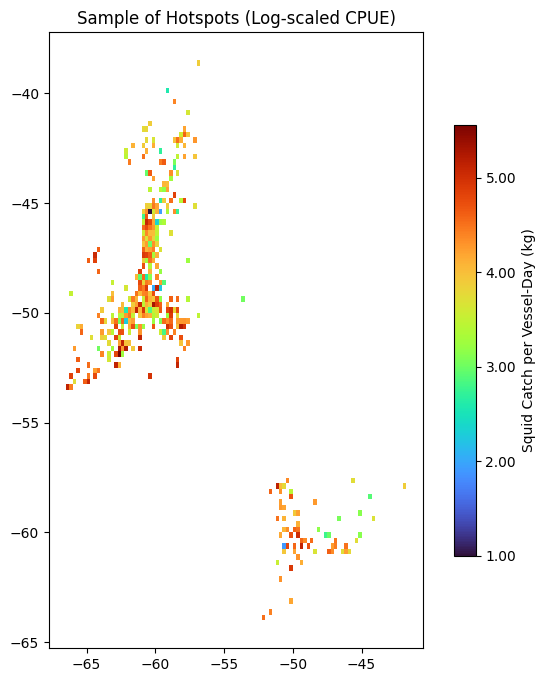

In [6]:

# Ensure reproducible sample
sample_hotspots = hotspots.sample(500, random_state=42)

# Fixed color scale based on full dataset
vmin = hotspots["cpue"].min()
vmax = hotspots["cpue"].max()

# Plot
ax = sample_hotspots.plot(
    column="cpue_log",
    cmap="turbo",
    legend=True,
    figsize=(8,8),
    legend_kwds={
        "label": "Squid Catch per Vessel-Day (kg)",
        "orientation": "vertical",
        "shrink": 0.7
    }
)


# Apply formatter to the colorbar after plotting
cbar = ax.get_figure().get_axes()[1]  # usually the colorbar is the second axes
cbar.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.2f}"))

plt.title("Sample of Hotspots (Log-scaled CPUE)")

# Ensure outputs folder exists
os.makedirs("../outputs/plots", exist_ok=True)

# Save figure
plt.savefig("../outputs/plots/sample_of_hotspots_colored_by_cpue.png", dpi=300, bbox_inches='tight')

plt.show()



## Summary

From 2000 to 2020, squid catch exhibited pronounced interannual variability with
clear boom–bust cycles rather than a stable long-term trend. Periods of very high
catch and CPUE (notably 2007–2008 and 2014–2015) occurred despite moderate fishing
effort, indicating that squid productivity is driven primarily by biological and
environmental conditions rather than effort alone. Conversely, sharp collapses
in catch and CPUE (e.g., 2004 and 2016) highlight the sensitivity of the fishery
to short-term changes in stock availability. In recent years, productivity has
remained below historical peaks despite stable effort, underscoring the need
for adaptive, CPUE-informed management and spatio-temporal analyses to support
decision-making.